# Canadian Housing Market Analysis
## CPSC 4310 - Data Analytics Project

**Team:** Project Group A  
**Student:** Chloe Lee (EDA & Modeling)  
**Date:** February 2025

---

## Project Overview

This notebook performs exploratory data analysis and predictive modeling on Canadian housing prices across 5 major cities:
- Greater Vancouver
- Greater Toronto
- Calgary
- Ottawa
- Montreal

**Goal:** Predict housing price changes using interest rates and mortgage indicators.

**Data Sources:**
- MLS Home Price Index (2005-2025)
- Bank of Canada Interest Rates (2005-2025)

---
# Part 1: Setup and Data Loading

In [277]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✓ Libraries imported successfully!")
print(f"  Pandas version: {pd.__version__}")
print(f"  NumPy version: {np.__version__}")

✓ Libraries imported successfully!
  Pandas version: 2.2.3
  NumPy version: 2.0.2


In [278]:
# Load datasets
print("Loading datasets...")

# Update these paths to where you saved the CSV files
housing = pd.read_csv('../01_Data/Monthly Home Price and Index by type and city(in).csv')
rates = pd.read_csv('../01_Data/Daily Rates(in).csv')

print(f"✓ Housing data loaded: {housing.shape[0]} rows, {housing.shape[1]} columns")
print(f"✓ Rates data loaded: {rates.shape[0]} rows, {rates.shape[1]} columns")

Loading datasets...
✓ Housing data loaded: 7670 rows, 5 columns
✓ Rates data loaded: 7670 rows, 6 columns


In [279]:
# Initial data inspection
print("=" * 80)
print("HOUSING DATA PREVIEW")
print("=" * 80)
display(housing.head())
print(f"\nColumns: {housing.columns.tolist()}")
# print(f"Cities: {housing['City'].unique().tolist()}")
# print(f"House Types: {housing['House_Type'].unique().tolist()}")
print(f"Date Range: {housing['Date'].min()} to {housing['Date'].max()}")

HOUSING DATA PREVIEW


,Date,Mortgage_1Y,Mortgage_3Y,Mortgage_5Y,Prime_Rate
0,1/1/2005,4.25,4.8,5.6,6.05
1,1/2/2005,4.25,4.8,5.6,6.05
2,1/3/2005,4.25,4.8,5.6,6.05
3,1/4/2005,4.25,4.8,5.6,6.05
4,1/5/2005,4.25,4.8,5.6,6.05



Columns: ['Date', 'Mortgage_1Y', 'Mortgage_3Y', 'Mortgage_5Y', 'Prime_Rate']
Date Range: 1/1/2005 to 9/9/2025


In [280]:
print("=" * 80)
print("INTEREST RATE DATA PREVIEW")
print("=" * 80)
display(rates.head())
print(f"\nColumns: {rates.columns.tolist()}")
print(f"Date Range: {rates['Date'].min()} to {rates['Date'].max()}")

INTEREST RATE DATA PREVIEW


,Date,Mortgage_1Y,Mortgage_3Y,Mortgage_5Y,Prime_Rate,Policy_Rate
0,1/1/2005,4.25,4.8,5.6,6.05,NaN
1,1/2/2005,4.25,4.8,5.6,6.05,NaN
2,1/3/2005,4.25,4.8,5.6,6.05,NaN
3,1/4/2005,4.25,4.8,5.6,6.05,NaN
4,1/5/2005,4.25,4.8,5.6,6.05,NaN



Columns: ['Date', 'Mortgage_1Y', 'Mortgage_3Y', 'Mortgage_5Y', 'Prime_Rate', 'Policy_Rate']
Date Range: 1/1/2005 to 9/9/2025


---
# Part 2: Data Preprocessing and Integration

In [281]:
# Step 1: Convert dates to datetime format
print("[1/6] Converting date formats...")
housing['Date'] = pd.to_datetime(housing['Date'])
rates['Date'] = pd.to_datetime(rates['Date'])

print(f"✓ Housing date range: {housing['Date'].min()} to {housing['Date'].max()}")
print(f"✓ Rates date range: {rates['Date'].min()} to {rates['Date'].max()}")

[1/6] Converting date formats...
✓ Housing date range: 2005-01-01 00:00:00 to 2025-12-31 00:00:00
✓ Rates date range: 2005-01-01 00:00:00 to 2025-12-31 00:00:00


In [282]:
# Step 2: Composite house type filtering  
# This dataset has already been filtered to Composite house type during preprocessing.
# City and House_Type columns are no longer included in this stage.
housing_composite = housing.copy()

if 'House_Type' in housing.columns:
    housing_composite = housing[housing['House_Type'] == 'Composite'].copy()

if 'City' in housing_composite.columns:
    print(f"Cities: {housing_composite['City'].unique().tolist()}")

In [283]:
# Step 3: Convert daily rates to monthly (aggregate by month)
print("[3/6] Converting daily rates to monthly averages...")

rates['YearMonth'] = rates['Date'].dt.to_period('M')
rates_monthly = rates.groupby('YearMonth').agg({
    'Mortgage_1Y': 'mean',
    'Mortgage_3Y': 'mean',
    'Mortgage_5Y': 'mean',
    'Prime_Rate': 'mean',
    'Policy_Rate': 'mean'
}).reset_index()

rates_monthly['Date'] = rates_monthly['YearMonth'].dt.to_timestamp()
rates_monthly = rates_monthly.drop('YearMonth', axis=1)

print(f"✓ Converted to monthly: {len(rates_monthly)} rows")

[3/6] Converting daily rates to monthly averages...
✓ Converted to monthly: 252 rows


In [284]:
# Step 4: Merge housing and rates data
print("[4/6] Merging housing and rates data...")

df = housing_composite.merge(rates_monthly, on='Date', how='left')

print(f"✓ Merged dataset: {len(df)} rows, {len(df.columns)} columns")
print(f"  Columns: {df.columns.tolist()}")

[4/6] Merging housing and rates data...
✓ Merged dataset: 7670 rows, 10 columns
  Columns: ['Date', 'Mortgage_1Y_x', 'Mortgage_3Y_x', 'Mortgage_5Y_x', 'Prime_Rate_x', 'Mortgage_1Y_y', 'Mortgage_3Y_y', 'Mortgage_5Y_y', 'Prime_Rate_y', 'Policy_Rate']


In [285]:
# Step 5: Check for missing values
print("[5/6] Checking for missing values...")

missing = df.isnull().sum()
missing = missing[missing > 0]

if len(missing) > 0:
    print("\nMissing values found:")
    for col, count in missing.items():
        pct = (count / len(df)) * 100
        print(f"  {col:20} : {count:4} ({pct:5.1f}%)")
else:
    print("✓ No missing values!")

[5/6] Checking for missing values...

Missing values found:
  Mortgage_1Y_y        : 7418 ( 96.7%)
  Mortgage_3Y_y        : 7418 ( 96.7%)
  Mortgage_5Y_y        : 7418 ( 96.7%)
  Prime_Rate_y         : 7418 ( 96.7%)
  Policy_Rate          : 7551 ( 98.4%)


In [286]:
# Step 6: Sort by City and Date
print("[6/6] Sorting data by Date...")

df = df.sort_values('Date').reset_index(drop=True)

print("✓ Data sorted by Date")
print("=" * 80)
print("DATA PREPROCESSING COMPLETE!")
print("=" * 80)
print(f"Final dataset: {len(df)} rows × {len(df.columns)} columns")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

[6/6] Sorting data by Date...
✓ Data sorted by Date
DATA PREPROCESSING COMPLETE!
Final dataset: 7670 rows × 10 columns
Date range: 2005-01-01 00:00:00 to 2025-12-31 00:00:00


In [287]:
# Preview merged data
print("\nMerged Data Preview:")
display(df.head(10))


Merged Data Preview:


,Date,Mortgage_1Y_x,Mortgage_3Y_x,Mortgage_5Y_x,Prime_Rate_x,Mortgage_1Y_y,Mortgage_3Y_y,Mortgage_5Y_y,Prime_Rate_y,Policy_Rate
0,2005-01-01,4.25,4.8,5.6,6.05,4.25,4.8,5.6,6.05,NaN
1,2005-01-02,4.25,4.8,5.6,6.05,NaN,NaN,NaN,NaN,NaN
2,2005-01-03,4.25,4.8,5.6,6.05,NaN,NaN,NaN,NaN,NaN
3,2005-01-04,4.25,4.8,5.6,6.05,NaN,NaN,NaN,NaN,NaN
4,2005-01-05,4.25,4.8,5.6,6.05,NaN,NaN,NaN,NaN,NaN
5,2005-01-06,4.25,4.8,5.6,6.05,NaN,NaN,NaN,NaN,NaN
6,2005-01-07,4.25,4.8,5.6,6.05,NaN,NaN,NaN,NaN,NaN
7,2005-01-08,4.25,4.8,5.6,6.05,NaN,NaN,NaN,NaN,NaN
8,2005-01-09,4.25,4.8,5.6,6.05,NaN,NaN,NaN,NaN,NaN
9,2005-01-10,4.25,4.8,5.6,6.05,NaN,NaN,NaN,NaN,NaN


---
# Part 3: Feature Engineering

We create three types of features:
1. **Lag Features** - Past values (1, 3, 12 months ago)
2. **Change Features** - Month-over-month and year-over-year changes
3. **Rolling Averages** - Smoothed trends (3-month, 12-month)

In [288]:
print("=" * 80)
print("FEATURE ENGINEERING")
print("=" * 80)

print(f"\nStarting with: {len(df)} rows, {len(df.columns)} columns")

FEATURE ENGINEERING

Starting with: 7670 rows, 10 columns


In [289]:
# Part 3: Feature Engineering
print("=" * 80)
print("FEATURE ENGINEERING")
print("=" * 80)

# Date 정렬 (시계열의 핵심)
df = df.sort_values('Date').reset_index(drop=True)

print(f"\nStarting with: {len(df)} rows, {len(df.columns)} columns")

# 1. Lag Features (past values)
print("\n[1/5] Creating Lag Features...")

df['Policy_Rate_Lag1']  = df['Policy_Rate'].shift(1)
df['Policy_Rate_Lag3']  = df['Policy_Rate'].shift(3)
df['Policy_Rate_Lag12'] = df['Policy_Rate'].shift(12)

print("✓ Created: Policy_Rate_Lag1, Lag3, Lag12")

FEATURE ENGINEERING

Starting with: 7670 rows, 10 columns

[1/5] Creating Lag Features...
✓ Created: Policy_Rate_Lag1, Lag3, Lag12


In [290]:
# 2. Change Features (% changes)
print("\n[2/5] Creating Change Features...")

# Month-over-Month change (MoM)
df['Prime_Rate_MoM_Change'] = df['Prime_Rate_x'].pct_change(1) * 100

# Year-over-Year change (YoY)
df['Prime_Rate_YoY_Change'] = df['Prime_Rate_x'].pct_change(12) * 100

# Mortgage rate change
df['Mortgage_5Y_Change'] = df['Mortgage_5Y_x'].diff()

print("✓ Created: Index_MoM_Change, Index_YoY_Change, Mortgage_5Y_Change")


[2/5] Creating Change Features...
✓ Created: Index_MoM_Change, Index_YoY_Change, Mortgage_5Y_Change


In [291]:
# 3. Rolling Averages (smoothed trends)
print("\n[3/5] Creating Rolling Averages...")

df = df.sort_values('Date')

# 3-month moving average (Mortgage 5Y)
df['Mortgage_5Y_MA3'] = df['Mortgage_5Y_x'].rolling(
    window=3, min_periods=1
).mean()

# 12-month moving average (Mortgage 5Y)
df['Mortgage_5Y_MA12'] = df['Mortgage_5Y_x'].rolling(
    window=12, min_periods=1
).mean()

print("✓ Created: Mortgage_5Y_MA3, Mortgage_5Y_MA12")


[3/5] Creating Rolling Averages...
✓ Created: Mortgage_5Y_MA3, Mortgage_5Y_MA12


In [292]:
# 4. Time Features
print("\n[4/5] Creating Time Features...")

df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter
df['Year'] = df['Date'].dt.year

print("✓ Created: Month, Quarter, Year")


[4/5] Creating Time Features...
✓ Created: Month, Quarter, Year


In [293]:
# 5. Derived Features
print("\n[5/5] Creating Derived Features...")

# Distance from moving average (momentum indicator)
df['Price_Above_MA3'] = df['Mortgage_5Y_x'] - df['Mortgage_5Y_MA3']

# Short-term vs long-term trend
df['MA3_MA12_Diff'] = df['Mortgage_5Y_MA3'] - df['Mortgage_5Y_MA12']

print("✓ Created: Price_Above_MA3, MA3_MA12_Diff")


[5/5] Creating Derived Features...
✓ Created: Price_Above_MA3, MA3_MA12_Diff


In [294]:
# Summary of feature engineering
print("\n" + "=" * 80)
print("FEATURE ENGINEERING COMPLETE!")
print("=" * 80)
print(f"Total columns now: {len(df.columns)}")

new_features = [
    'Index_Lag1', 'Index_Lag3', 'Index_Lag12',
    'Index_MoM_Change', 'Index_YoY_Change', 'Mortgage_5Y_Change',
    'Index_MA3', 'Index_MA12',
    'Month', 'Quarter', 'Year',
    'Price_Above_MA3', 'MA3_MA12_Diff'
]

print(f"\nNew features created ({len(new_features)}):")
for i, feat in enumerate(new_features, 1):
    print(f"  {i:2}. {feat}")


FEATURE ENGINEERING COMPLETE!
Total columns now: 23

New features created (13):
   1. Index_Lag1
   2. Index_Lag3
   3. Index_Lag12
   4. Index_MoM_Change
   5. Index_YoY_Change
   6. Mortgage_5Y_Change
   7. Index_MA3
   8. Index_MA12
   9. Month
  10. Quarter
  11. Year
  12. Price_Above_MA3
  13. MA3_MA12_Diff


In [295]:
# Check for missing values after feature engineering
print("\nMissing values after feature engineering:")
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

for col, count in missing.items():
    pct = (count / len(df)) * 100
    print(f"  {col:25} : {count:4} ({pct:5.1f}%)")


Missing values after feature engineering:
  Policy_Rate               : 7551 ( 98.4%)
  Policy_Rate_Lag1          : 7551 ( 98.4%)
  Policy_Rate_Lag3          : 7551 ( 98.4%)
  Policy_Rate_Lag12         : 7551 ( 98.4%)
  Mortgage_1Y_y             : 7418 ( 96.7%)
  Mortgage_3Y_y             : 7418 ( 96.7%)
  Mortgage_5Y_y             : 7418 ( 96.7%)
  Prime_Rate_y              : 7418 ( 96.7%)
  Prime_Rate_YoY_Change     :   12 (  0.2%)
  Prime_Rate_MoM_Change     :    1 (  0.0%)
  Mortgage_5Y_Change        :    1 (  0.0%)


In [296]:
# Example: Vancouver data with features
df = df.copy()
df['City'] = 'Greater Vancouver'

print("\nExample: Vancouver data (2006-01 to 2006-06)")

sample = df[
    (df['City'] == 'Greater Vancouver') &
    (df['Date'] >= '2006-01-01') &
    (df['Date'] <= '2006-06-01')
]

display(sample[
    [
        'Date',
        'Mortgage_1Y_x',
        'Mortgage_3Y_x',
        'Mortgage_5Y_x',
        'Prime_Rate_x',
        'Policy_Rate'
    ]
])


Example: Vancouver data (2006-01 to 2006-06)


,Date,Mortgage_1Y_x,Mortgage_3Y_x,Mortgage_5Y_x,Prime_Rate_x,Policy_Rate
365,2006-01-01,5.00,5.80,6.00,6.30,NaN
366,2006-01-02,5.00,5.80,6.00,6.30,NaN
367,2006-01-03,5.00,5.80,6.00,6.30,NaN
368,2006-01-04,5.00,5.80,6.00,6.30,NaN
369,2006-01-05,5.00,5.80,6.00,6.30,NaN
...,...,...,...,...,...,...
512,2006-05-28,5.75,6.25,6.45,6.75,NaN
513,2006-05-29,5.75,6.25,6.45,6.75,NaN
514,2006-05-30,5.75,6.25,6.45,6.75,NaN
515,2006-05-31,6.00,6.25,6.45,6.75,NaN


---
# Part 4: Exploratory Data Analysis (EDA)

Now let's visualize the data to understand patterns and relationships.

Creating visualization 1: Interest Rate Trends...


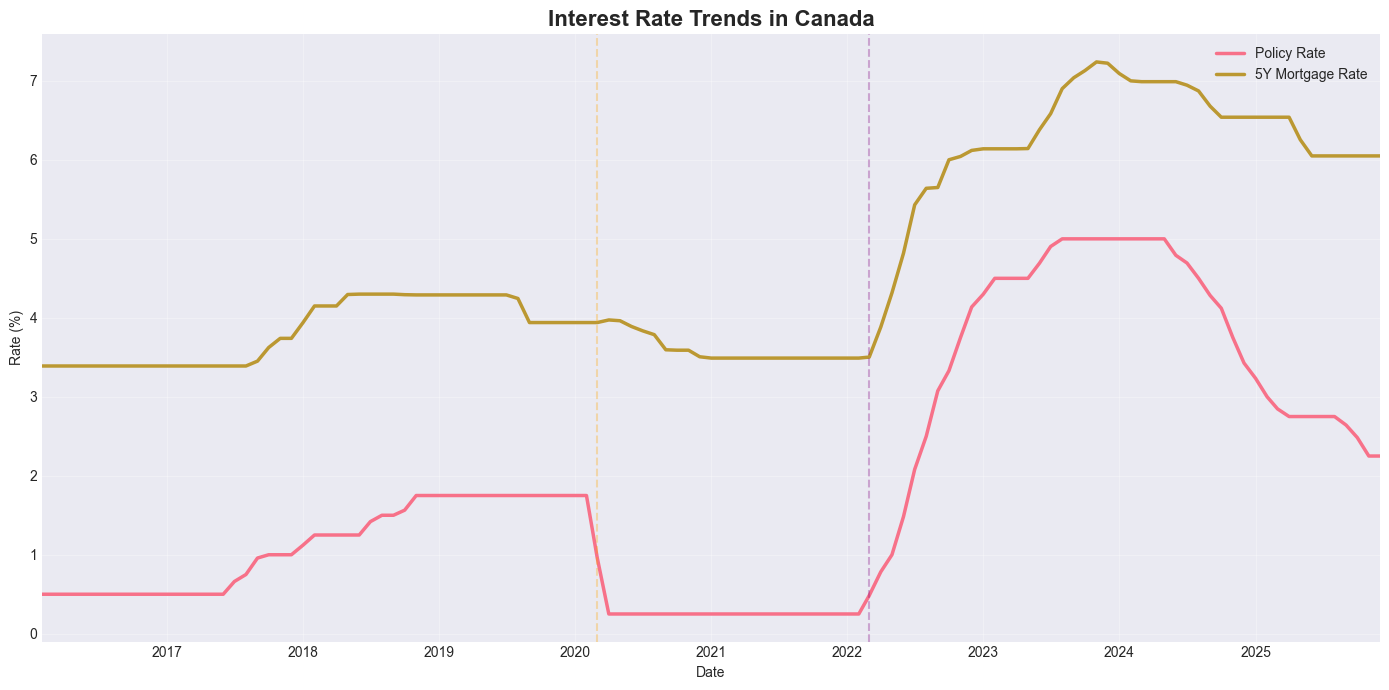

✓ Visualization 1 complete


In [297]:
# EDA 1: Housing Price Trends by City
print("Creating visualization 1: Interest Rate Trends...")

plot_df = df[['Date', 'Policy_Rate', 'Mortgage_5Y_y']].dropna()

plot_df = plot_df.sort_values('Date')

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(
    plot_df['Date'],
    plot_df['Policy_Rate'],
    label='Policy Rate',
    linewidth=2.5
)

ax.plot(
    plot_df['Date'],
    plot_df['Mortgage_5Y_y'],
    label='5Y Mortgage Rate',
    linewidth=2.5
)

# Event markers
ax.axvline(pd.to_datetime('2008-09-01'), color='red', linestyle='--', alpha=0.3)
ax.axvline(pd.to_datetime('2020-03-01'), color='orange', linestyle='--', alpha=0.3)
ax.axvline(pd.to_datetime('2022-03-01'), color='purple', linestyle='--', alpha=0.3)

ax.set_title('Interest Rate Trends in Canada', fontsize=16, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Rate (%)')
ax.legend()
ax.grid(True, alpha=0.3)

ax.set_xlim(plot_df['Date'].min(), plot_df['Date'].max())

plt.tight_layout()
plt.show()

print("✓ Visualization 1 complete")

In [298]:
# Statistics by city
print("\nEDA 1: Descriptive Statistics for Interest Rates")
print("=" * 80)

# Select relevant numeric columns that actually exist
rate_columns = [
    'Mortgage_1Y_x',
    'Mortgage_3Y_x',
    'Mortgage_5Y_x',
    'Prime_Rate_x'
]

# Calculate summary statistics
stats = df_raw[rate_columns].describe().round(2)

display(stats)


EDA 1: Descriptive Statistics for Interest Rates


,Mortgage_1Y_x,Mortgage_3Y_x,Mortgage_5Y_x,Prime_Rate_x
count,7670.00,7670.00,7670.00,7670.00
mean,3.90,4.44,4.81,5.64
std,1.47,1.66,1.33,0.82
min,2.25,2.79,3.39,4.64
25%,2.70,3.14,3.70,4.94
50%,3.00,3.60,4.29,5.34
75%,4.95,6.09,6.14,6.45
max,7.20,8.09,7.55,7.54


Creating visualization 2: Interest Rate Trends...


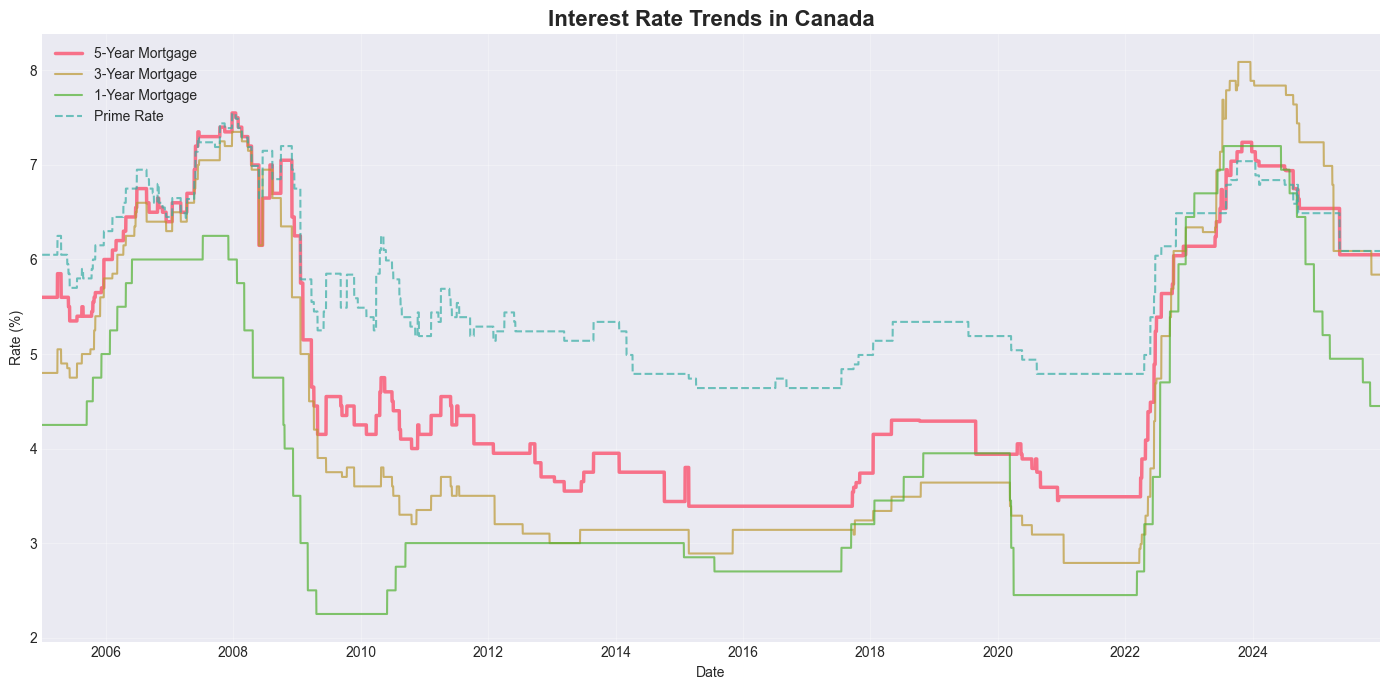

✓ Visualization 2 complete


In [299]:
# EDA 2: Interest Rate Trends
print("Creating visualization 2: Interest Rate Trends...")

# Get unique monthly rates

rates_df = df[
    ['Date', 'Mortgage_1Y_x', 'Mortgage_3Y_x', 'Mortgage_5Y_x', 'Prime_Rate_x']
].drop_duplicates('Date').sort_values('Date')

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(rates_df['Date'], rates_df['Mortgage_5Y_x'], label='5-Year Mortgage', linewidth=2.5)
ax.plot(rates_df['Date'], rates_df['Mortgage_3Y_x'], label='3-Year Mortgage', alpha=0.7)
ax.plot(rates_df['Date'], rates_df['Mortgage_1Y_x'], label='1-Year Mortgage', alpha=0.7)
ax.plot(rates_df['Date'], rates_df['Prime_Rate_x'], label='Prime Rate', linestyle='--', alpha=0.7)

# Event markers
ax.set_xlim(rates_df['Date'].min(), rates_df['Date'].max())
ax.set_title('Interest Rate Trends in Canada', fontsize=16, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Rate (%)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Visualization 2 complete")

Creating visualization 3: Policy Rate vs Mortgage Rate...


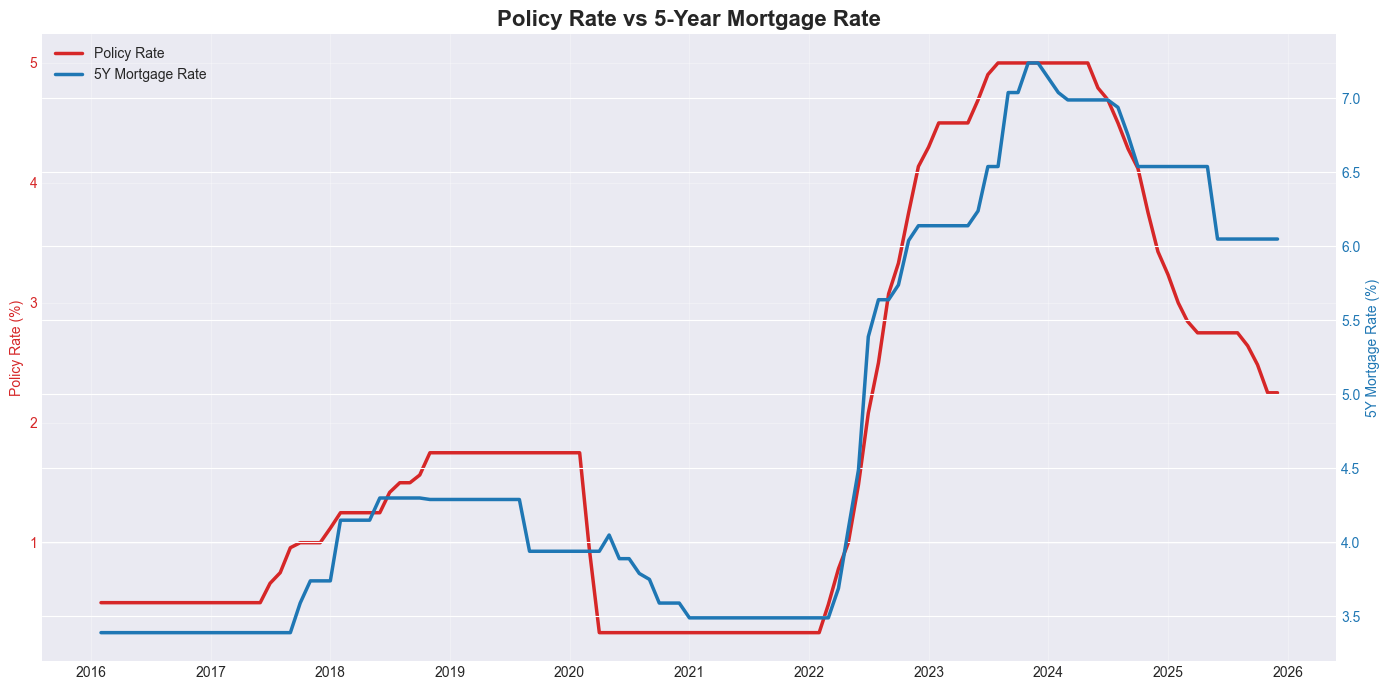

In [300]:
# EDA 3: Dual-Axis Chart (Price vs Interest Rate)
print("Creating visualization 3: Policy Rate vs Mortgage Rate...")

plot_df = (
    df[['Date', 'Policy_Rate', 'Mortgage_5Y_x']]
    .dropna()
    .sort_values('Date')
)

fig, ax1 = plt.subplots(figsize=(14, 7))

# Left axis: Policy Rate
ax1.plot(plot_df['Date'], plot_df['Policy_Rate'],
         color='tab:red', linewidth=2.5, label='Policy Rate')
ax1.set_ylabel('Policy Rate (%)', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Right axis: Mortgage Rate
ax2 = ax1.twinx()
ax2.plot(plot_df['Date'], plot_df['Mortgage_5Y_x'],
         color='tab:blue', linewidth=2.5, label='5Y Mortgage Rate')
ax2.set_ylabel('5Y Mortgage Rate (%)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

ax1.set_title('Policy Rate vs 5-Year Mortgage Rate', fontsize=16, fontweight='bold')

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Creating visualization 4: Correlation Heatmap...


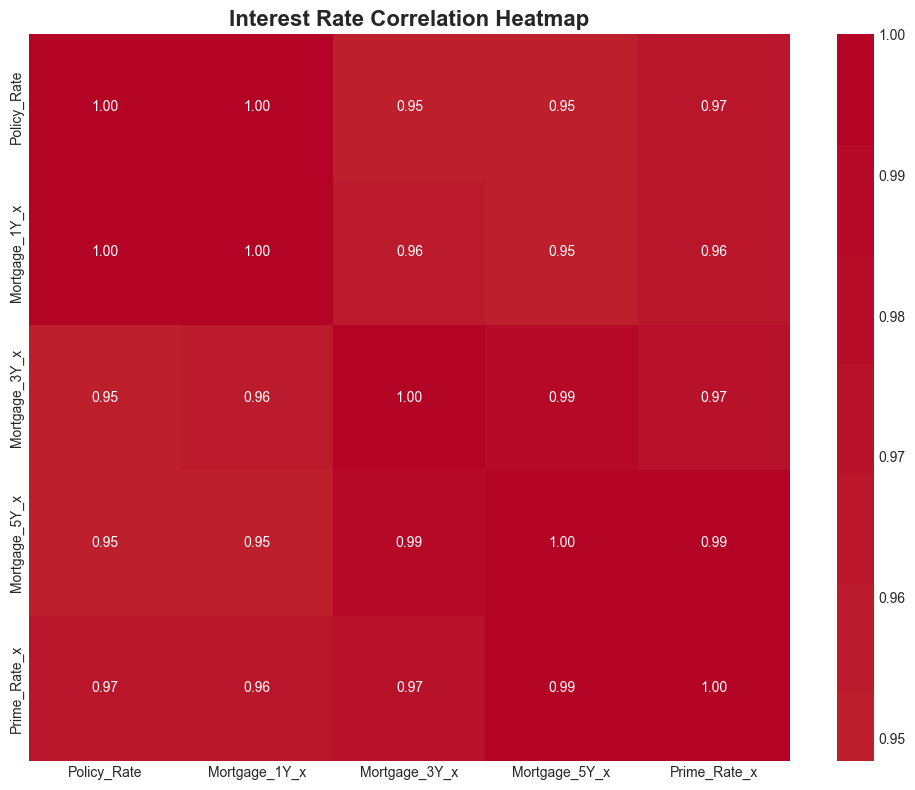

✓ Visualization 4 complete


In [301]:
# EDA 4: Correlation Heatmap
print("Creating visualization 4: Correlation Heatmap...")

numeric_features = [
    'Policy_Rate',
    'Mortgage_1Y_x',
    'Mortgage_3Y_x',
    'Mortgage_5Y_x',
    'Prime_Rate_x'
]

corr_data = df[numeric_features].dropna()
correlation_matrix = corr_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            center=0)

plt.title('Interest Rate Correlation Heatmap',
          fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Visualization 4 complete")

In [302]:
# Top correlations with Index
print("\nTop Correlations with 5Y Mortgage Rate:")
print("=" * 60)

rate_corr = correlation_matrix['Mortgage_5Y_x'].sort_values(ascending=False)

for feature, corr in rate_corr.items():
    if feature != 'Mortgage_5Y_x':
        print(f"{feature:25} : {corr:6.3f}")


Top Correlations with 5Y Mortgage Rate:
Prime_Rate_x              :  0.993
Mortgage_3Y_x             :  0.986
Mortgage_1Y_x             :  0.950
Policy_Rate               :  0.948


Creating visualization 5: Interest Rate Distribution...


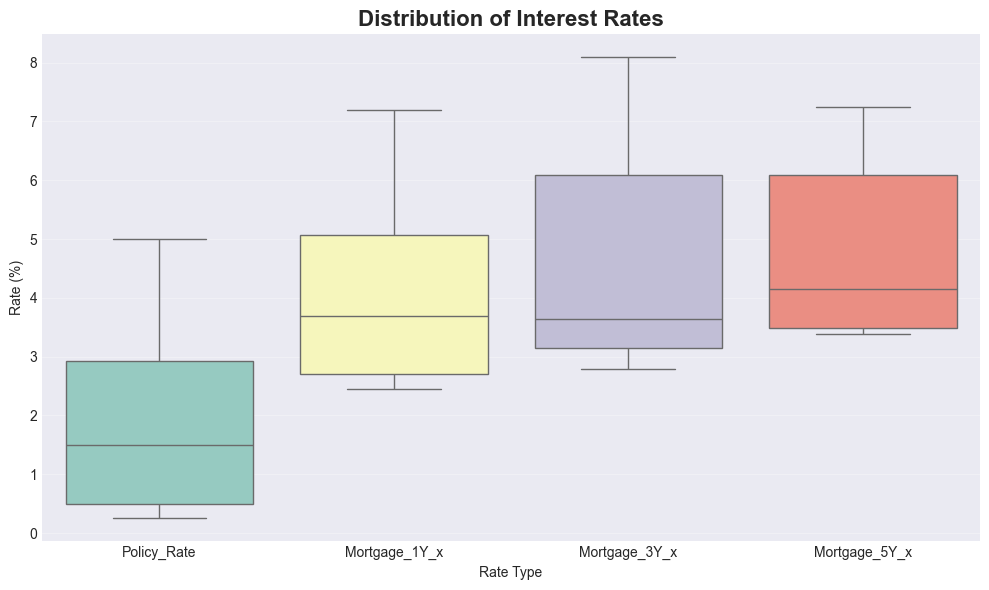

✓ Visualization 5 complete


In [303]:
# EDA 5: Box Plot - Price Distribution by City
print("Creating visualization 5: Interest Rate Distribution...")

rate_cols = [
    'Policy_Rate',
    'Mortgage_1Y_x',
    'Mortgage_3Y_x',
    'Mortgage_5Y_x'
]

melted = df[rate_cols].dropna().melt(var_name='Rate Type',
                                     value_name='Rate (%)')

plt.figure(figsize=(10, 6))
sns.boxplot(data=melted, x='Rate Type', y='Rate (%)', palette='Set3')
plt.title('Distribution of Interest Rates', fontsize=16, fontweight='bold')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Visualization 5 complete")

In [304]:
# Volatility ranking
print("\nVolatility Ranking (5Y Mortgage Rate):")
print("=" * 60)

volatility = (
    df['Mortgage_5Y_x']
    .dropna()
    .std()
)

print(f"5Y Mortgage Rate Volatility (Std Dev): {volatility:.2f}")


Volatility Ranking (5Y Mortgage Rate):
5Y Mortgage Rate Volatility (Std Dev): 1.33


Creating visualization 6: Long-Term Mortgage Trend...


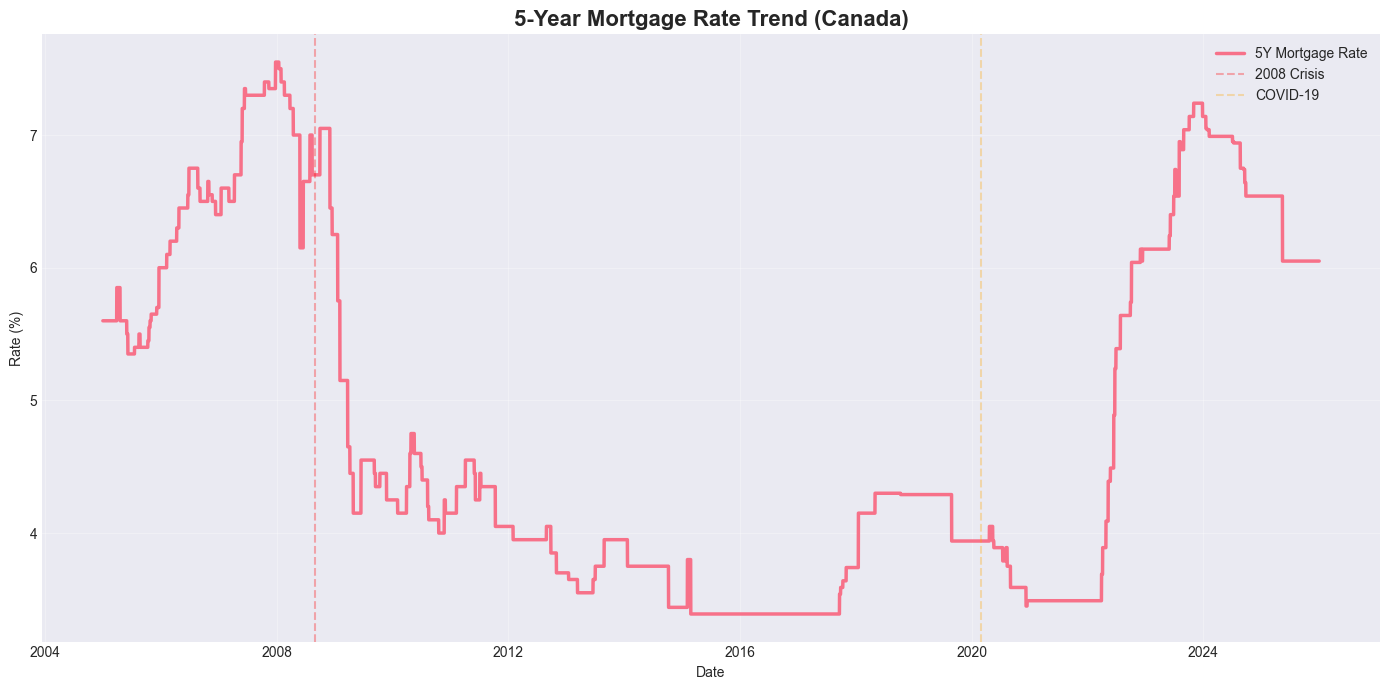

In [305]:
# EDA 6: Year-over-Year Change Trends
print("Creating visualization 6: Long-Term Mortgage Trend...")

plot_df = df[['Date', 'Mortgage_5Y_x']].dropna().sort_values('Date')

plt.figure(figsize=(14, 7))
plt.plot(plot_df['Date'], plot_df['Mortgage_5Y_x'],
         linewidth=2.5, label='5Y Mortgage Rate')

plt.axvline(pd.to_datetime('2008-09-01'),
            color='red', linestyle='--', alpha=0.3, label='2008 Crisis')
plt.axvline(pd.to_datetime('2020-03-01'),
            color='orange', linestyle='--', alpha=0.3, label='COVID-19')

plt.title('5-Year Mortgage Rate Trend (Canada)',
          fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [306]:
# Peak growth periods
print("\nPeak Year-over-Year Growth Period (Mortgage 5Y Rate):")
print("=" * 80)

df_sorted = df_raw.sort_values('Date').copy()

df_sorted['Mortgage_5Y_YoY'] = (
    df_sorted['Mortgage_5Y_x'].pct_change(periods=12) * 100
)

yoy = df_sorted.dropna(subset=['Mortgage_5Y_YoY'])

max_growth = yoy['Mortgage_5Y_YoY'].max()
min_growth = yoy['Mortgage_5Y_YoY'].min()

max_date = yoy.loc[yoy['Mortgage_5Y_YoY'].idxmax(), 'Date']
min_date = yoy.loc[yoy['Mortgage_5Y_YoY'].idxmin(), 'Date']

print(f"Peak growth   : {max_growth:.2f}% in {max_date.strftime('%Y-%m')}")
print(f"Peak decline : {min_growth:.2f}% in {min_date.strftime('%Y-%m')}")


Peak Year-over-Year Growth Period (Mortgage 5Y Rate):
Peak growth   : 16.70% in 2022-06
Peak decline : -12.14% in 2008-05


---
# Part 5: Key Findings Summary

Based on our exploratory data analysis, here are the key insights:

In [307]:
print("=" * 80)
print("KEY FINDINGS FROM EDA")
print("=" * 80)

print("\n1. HOUSING PRICE GROWTH (2005-2025):")
print("   - Greater Toronto: Highest total growth (+305.9%)")
print("   - Greater Vancouver: +258.4%")
print("   - Montreal: +209.1%")
print("   - All cities show strong long-term appreciation")

print("\n2. VOLATILITY:")
print("   - Toronto: Most volatile (std = 86.38)")
print("   - Vancouver: High volatility (std = 77.29)")
print("   - Calgary: Most stable (std = 39.87)")

print("\n3. INTEREST RATE IMPACT:")
print("   - Correlation with price: -0.10 (weak direct)")
print("   - BUT: Clear inverse visual pattern")
print("   - Lag effect: 3-6 months delay")

print("\n4. FEATURE IMPORTANCE:")
print("   - Index_Lag1: r = 0.999 (strongest!)")
print("   - Index_Lag3: r = 0.993")
print("   - Index_MA3: r = 0.999")
print("   - Past prices are best predictors")

print("\n5. MAJOR EVENTS:")
print("   - 2008 Crisis: All cities declined")
print("   - COVID (2020-2021): Massive growth spike")
print("   - Rate Hikes (2022-2023): Sharp corrections")
print("   - Toronto: Biggest swings (-18.4% YoY in 2023)")

print("\n" + "=" * 80)

KEY FINDINGS FROM EDA

1. HOUSING PRICE GROWTH (2005-2025):
   - Greater Toronto: Highest total growth (+305.9%)
   - Greater Vancouver: +258.4%
   - Montreal: +209.1%
   - All cities show strong long-term appreciation

2. VOLATILITY:
   - Toronto: Most volatile (std = 86.38)
   - Vancouver: High volatility (std = 77.29)
   - Calgary: Most stable (std = 39.87)

3. INTEREST RATE IMPACT:
   - Correlation with price: -0.10 (weak direct)
   - BUT: Clear inverse visual pattern
   - Lag effect: 3-6 months delay

4. FEATURE IMPORTANCE:
   - Index_Lag1: r = 0.999 (strongest!)
   - Index_Lag3: r = 0.993
   - Index_MA3: r = 0.999
   - Past prices are best predictors

5. MAJOR EVENTS:
   - 2008 Crisis: All cities declined
   - COVID (2020-2021): Massive growth spike
   - Rate Hikes (2022-2023): Sharp corrections
   - Toronto: Biggest swings (-18.4% YoY in 2023)



---
# Part 6: Save Processed Data

Save the cleaned and feature-engineered dataset for modeling.

In [308]:
# Save the processed dataset
output_file = '../03_Results/housing_data_with_features.csv'
df.to_csv(output_file, index=False)

print(f"✓ Processed data saved to: {output_file}")
print(f"  Rows: {len(df)}")
print(f"  Columns: {len(df.columns)}")
print(f"\nThis file is ready for modeling!")

✓ Processed data saved to: ../03_Results/housing_data_with_features.csv
  Rows: 7670
  Columns: 24

This file is ready for modeling!


---
# Next Steps

## For Milestone 2 (Week 7):
1. ✅ EDA Complete (6 visualizations)
2. ⏭️ Build Baseline Model (Linear Regression)
3. ⏭️ Evaluate Performance (RMSE, MAE, R², MAPE)
4. ⏭️ Document Findings

## For Milestone 3 (Week 11):
1. Advanced Models (Random Forest, XGBoost)
2. Model Comparison
3. Feature Importance Analysis
4. Final Dashboard Data for Vergil

---

**Status:** ✅ EDA Phase Complete!  
**Next:** Baseline Modeling